## Source https://www.kaggle.com/c/titanic/data

In [88]:
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

### First read the data and take an overview

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dataset contains 866 NaN values which is significant number. It is better idea to fill NaN values with unique value than to drop these rows. For numeric column it is -1, for object columns 'Unknown'

In [6]:
values = {"Age":-1,"Cabin":"Unknown","Embarked":"Unknown"}
df = df.fillna(value=values)

### Basic model

Let's define function to assign target variable and features, then run cross validation model

In [7]:
def model_func(features, model, scor, cv_num):
    X = df[features]
    y = df['Survived']
    return cross_val_score(model,X,y,scoring=scor, cv=cv_num).mean()


And test this function on an early stage

In [8]:
features = (["Pclass","Age","Parch","Fare","SibSp"])
model_func(features,RandomForestClassifier(),"accuracy",4)

0.6835702364359876

### Feature Engineering

First most obvious thought is to switch Sex column into 0, 1 values. Take a look whether it contains only two categories

#### Sex

In [9]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
df['Sex_cat'] = df["Sex"].map(lambda x: int(x=='male'))

#### Cabin

In [11]:
df['Cabin'].value_counts()

Unknown        687
G6               4
B96 B98          4
C23 C25 C27      4
F2               3
F33              3
E101             3
D                3
C22 C26          3
E8               2
E24              2
E67              2
C78              2
B5               2
D33              2
B77              2
D36              2
C2               2
F G73            2
C124             2
C123             2
C126             2
B22              2
E25              2
D35              2
C92              2
B20              2
C125             2
D17              2
C93              2
              ... 
C148             1
A6               1
B69              1
C95              1
D9               1
E34              1
E50              1
E12              1
E36              1
B79              1
C91              1
D45              1
C128             1
B4               1
C99              1
C62 C64          1
C110             1
C103             1
E49              1
F38              1
E58              1
C101        

That doesn't tell too much. Let's extract first letter; Unknown is U. 

In [12]:
def first_letter(string):
    if not string[0].isdigit():
        return string[0]
    

In [13]:
df['Cabin_letter'] = df['Cabin'].apply(first_letter)

In [14]:
df['Cabin_letter'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_letter, dtype: int64

In [15]:
cabin_letters_list = list(df['Cabin_letter'].value_counts().head(7).keys())
cabin_letters_list = ["Cabin_letter_" + name for name in cabin_letters_list]
cabin_letters_list

['Cabin_letter_U',
 'Cabin_letter_C',
 'Cabin_letter_B',
 'Cabin_letter_D',
 'Cabin_letter_E',
 'Cabin_letter_A',
 'Cabin_letter_F']

Make 7 columns representing 7 most common cabin letters. For this purpose use get dummies.

In [16]:
dummies = pd.get_dummies(df,columns=['Cabin_letter'])

In [17]:
df = pd.concat([df,dummies[cabin_letters_list]], axis=1)

##### Name 
Notice that every title is after comma ends with period. It allows to easily extract this title from the Name

In [18]:
df["Title"] = df["Name"].map(lambda x: x.split(",")[1].split('.')[0].strip())

In [19]:
df.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Sir               1
Lady              1
Capt              1
the Countess      1
Jonkheer          1
Mme               1
Don               1
Ms                1
Name: Title, dtype: int64

To simpify make a column with only four first titles and the others

In [20]:
top_titles = list(df['Title'].value_counts().head(4).keys())
top_titles

['Mr', 'Miss', 'Mrs', 'Master']

In [21]:
def title_top(title):
    if title in top_titles:
        return 1
    else:
        return 0

In [22]:
df['Title_top'] = df['Title'].apply(title_top)

In [23]:
df["Title_top"].value_counts()

1    864
0     27
Name: Title_top, dtype: int64

In [24]:
top_titles = list(df['Title'].value_counts().head(4).keys())
top_titles = ["Title_" + name for name in top_titles]

In [25]:
dummies = pd.get_dummies(df,columns=['Title'])
df = pd.concat([df,dummies[top_titles]], axis=1)

#### Embarked (Port of embarkation)

In [26]:
df["Embarked"].value_counts()

S          644
C          168
Q           77
Unknown      2
Name: Embarked, dtype: int64

One Hot Encoding

In [27]:
top_embarked = list(df['Embarked'].value_counts().head(3).keys())
top_embarked = ["Embarked_" + name for name in top_embarked]

In [28]:
dummies = pd.get_dummies(df,columns=['Embarked'])
df = pd.concat([df,dummies[top_titles]], axis=1)

#### Number of siblings/spouse and parents/children aboard

In [29]:
df["Family_size"] = df['SibSp'] + df['Parch']
df["Family_size"].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family_size, dtype: int64

If Family size is 0 then there is a loner

In [30]:
df["Loner"] = df["Family_size"].map(lambda x: x==0)

If Family size is 1 - 5 then this is small family

In [31]:
df['Family_small'] = df['Family_size'].map(lambda x: int(1<= x <= 5))

If Family size is larger than 5 then is big family

In [32]:
df['Family_big'] = df['Family_size'].map(lambda x: int(x > 5))

#### Fare

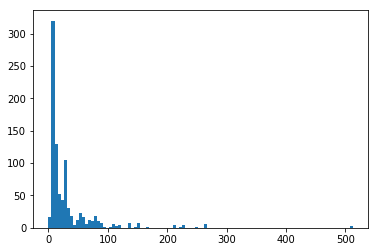

In [33]:
plt.hist(df["Fare"], bins=100)
plt.show()

Consider splitting fare into four categories: 0-50, 50-100, 100-200, 200-300 more than 300

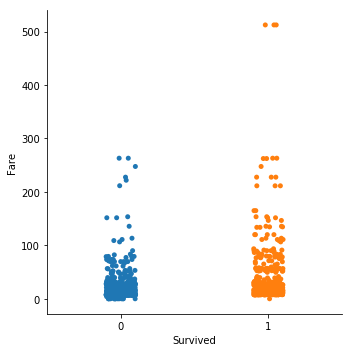

In [34]:
sns.catplot(x ='Survived', y = 'Fare', data = df)

In [35]:
def fare_cats(fare):
    if 0 <= fare < 50:
        return 0
    elif 50 <= fare < 100:
        return 1
    elif 100 <= fare < 200:
        return 2
    elif 200 <= fare < 300:
        return 3
    elif fare >= 300:
        return 4

In [36]:
df["Fare_cats"] = df["Fare"].apply(fare_cats)
df["Fare_cats"].value_counts()

0    730
1    108
2     33
3     17
4      3
Name: Fare_cats, dtype: int64

Fare logarithm

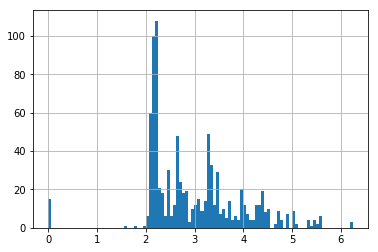

In [37]:
np.log(df['Fare'] + 1).hist(bins = 100)

In [38]:
df['Fare_log'] = np.log(df['Fare'] + 1)

#### Age
Combine data with Sex column and divide into three categories: child (less than 16 yo), female adult and male adult

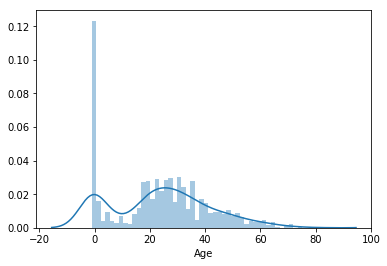

In [39]:
sns.distplot(df['Age'], bins=50)

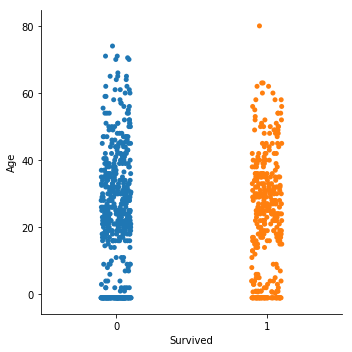

In [40]:
sns.catplot(x = 'Survived', y = 'Age', data = df)

No explicit pattern. Make a column indicating previous NaN (-1) value.

In [41]:
df['Age_NaN'] = df['Age'].map(lambda x: x==-1)

Combine data with Sex column and divide into three categories: child (less than 16 yo), female adult and male adult

In [42]:
def child_adult_sex(age, sex):
    if age <= 16: return 'child'
    elif sex == 'male': return 'male_adult'
    elif sex == 'female':return 'female_adult'

In [43]:
df['child_adult_sex'] = df.apply(lambda x: child_adult_sex(x.Age, x.Sex), axis=1)

In [44]:
df['child_adult_sex_fact'] = df['child_adult_sex'].factorize()[0]

### Pivot tables

It may be inventive to use pivot to see what percentage of survivors is while we combine two features together

In [45]:
df.pivot_table(values=['Survived'], index = ["Sex","Pclass"], aggfunc=np.mean)

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

In [46]:
df.pivot_table(values=['Survived'], index = ["Title_top","Pclass"], aggfunc=np.mean)

Survived
Title_top Pclass          
0         1       0.611111
          2       0.111111
1         1       0.631313
          2       0.491429
          3       0.242363

In [47]:
df.pivot_table(values=['Survived'], index = ["Embarked","Pclass"], aggfunc=np.mean)

Survived
Embarked Pclass          
C        1       0.694118
         2       0.529412
         3       0.378788
Q        1       0.500000
         2       0.666667
         3       0.375000
S        1       0.582677
         2       0.463415
         3       0.189802
Unknown  1       1.000000

Masters, misses and Mrs from class 1 and 2 had great chance to survive. Create a column which points them with 1

In [48]:
def title_pclass(title, pclass):
    if pclass in [1,2]:
        if title in ['Master','Miss','Mrs']:
            return 1
        else:
            return 0
    else:
        return 0

In [49]:
df['title_pclass'] = df.apply(lambda x: title_pclass(x.Title_top,x.Pclass), axis=1)

### Correlation

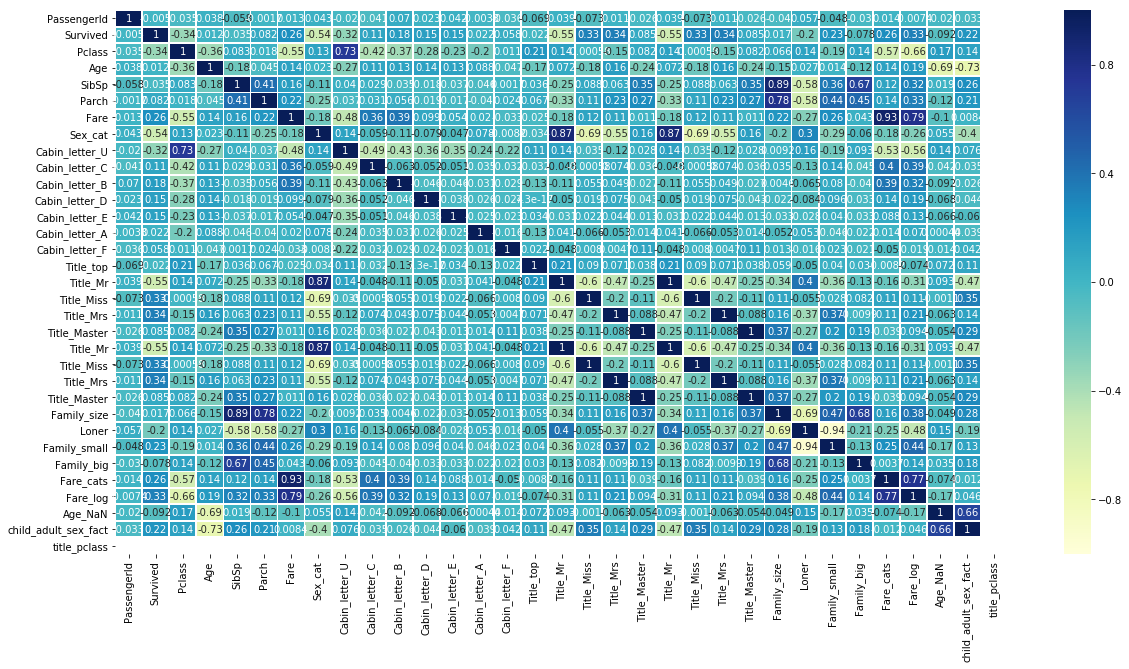

In [58]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

Heatmap above shows how particula features correlate with each other. This may be helpful while determinig which feature improves model, which not and which is redundand (has strong correlation with column other than Target and can be omitted).

## Model construction and adjusting

First select features with most correlation and run for a few models

In [70]:
def train_validate(model, X, y):
    skf = StratifiedKFold(n_splits = 7, shuffle= True)
    
    scores = []
    for train_idx, test_idx in skf.split(X,y):
        model.fit(X[train_idx],y[train_idx])
        y_pred = model.predict(X[test_idx])
        
        score = accuracy_score(y[test_idx],y_pred)
        scores.append(score)      
    result = np.mean(scores)
    
    return result

### Model type choice

In [71]:
models = [ExtraTreeClassifier(), RandomForestClassifier(),DecisionTreeClassifier(),xgb.XGBClassifier()]

features = ['Age','Sex_cat','title_pclass','Family_size']

y = df['Survived'].values
X = df[features].values


for model in models:
    print(model)
    print(train_validate(model,X,y))


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
0.7711579300355311
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.7789702905440391
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_

Approximately XGBClassifier is doing best job.

Now, try to choose randomly features and find what combination has the greatest potential.

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 41 columns):
PassengerId             891 non-null int64
Survived                891 non-null int64
Pclass                  891 non-null int64
Name                    891 non-null object
Sex                     891 non-null object
Age                     891 non-null float64
SibSp                   891 non-null int64
Parch                   891 non-null int64
Ticket                  891 non-null object
Fare                    891 non-null float64
Cabin                   891 non-null object
Embarked                891 non-null object
Sex_cat                 891 non-null int64
Cabin_letter            891 non-null object
Cabin_letter_U          891 non-null uint8
Cabin_letter_C          891 non-null uint8
Cabin_letter_B          891 non-null uint8
Cabin_letter_D          891 non-null uint8
Cabin_letter_E          891 non-null uint8
Cabin_letter_A          891 non-null uint8
Cabin_letter_F          8

In [73]:
def get_feats(df):
    black_list = ['PassengerId','Survived']
    feats = df.select_dtypes(include=[np.number]).columns.values
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats

In [75]:
features_all = get_feats(df)
len(features_all)

29

In [87]:
best_score = 0
best_feats = []

y = df['Survived'].values

for i in range(1,27): # there are 26 numeric or bool features
    for a in range(35): # 35 repeat times
        features = np.random.choice(features_all,i,replace = False).tolist()
        X = df[features].values
        score = train_validate(ExtraTreeClassifier(),X,y)
        
        if score > best_score:
            best_score = score
            best_feats = features


print('Best score is {0} with features: {1}'.format(best_score,best_feats))
        


Best score is 0.8361901190922563 with features: ['Title_Master', 'Title_Mr', 'Pclass', 'Fare', 'Sex_cat']


ExtraTreeClassifier

Best score is 0.8429129115556986 with features: ['Sex_cat', 'Pclass', 'Fare_log', 'Cabin_letter_B', 'Cabin_letter_C', 'Title_Mr', 'Cabin_letter_A', 'Title_Master']

RandomForestClassifier

Best score is 0.8361634762172585 with features: ['Title_top', 'Family_small', 'Fare', 'title_pclass', 'SibSp', 'Cabin_letter_A', 'Title_Mr', 'Sex_cat', 'Title_Miss', 'Parch', 'Family_big', 'Pclass', 'Fare_log', 'Title_Mrs', 'Cabin_letter_F', 'Cabin_letter_D', 'Title_Mr', 'Age', 'Cabin_letter_B', 'Title_Miss']

DecisionTreeClassifier

Best score is 0.8395559093059796 with features: ['Pclass', 'Title_Mrs', 'Title_Mr', 'Fare', 'Fare_log', 'Cabin_letter_D', 'Title_top', 'Title_Mrs', 'Sex_cat', 'title_pclass', 'Family_big']

XGBClassifier

Best score is 0.8462611258414129 with features: ['child_adult_sex_fact', 'Title_Mr', 'Parch', 'Family_size', 'Family_small', 'Cabin_letter_D', 'Pclass', 'Title_Mr', 'title_pclass', 'SibSp', 'Age', 'Fare_log', 'Family_big', 'Cabin_letter_B', 'Title_Mrs', 'Title_Master', 'Title_top', 'Cabin_letter_A', 'Title_Miss', 'Cabin_letter_E', 'Title_Master']

### Hyperparameters optimization

For the next step let's take two best models: XGBClassfier and ExtraTreeClassifier.

#### ExtraTreeClassifier

In [115]:
features = ['Sex_cat', 'Pclass', 'Fare_log', 'Cabin_letter_B', 'Cabin_letter_C', 'Title_Mr', 'Cabin_letter_A', 'Title_Master']
X = df[features].values
y = df['Survived'].values

def objective(space):
    params = {
        'max_depth':int(space['max_depth']),
        'min_samples_split':int(space['min_samples_split']),
        'splitter':space['splitter'],
        'criterion':space['criterion'],
        'max_features':int(space['max_features'])
    }
    
    model = ExtraTreeClassifier(**params)
    
    score = 1 - train_validate(model,X,y)
    print('Score: {0}'.format(score))
    return {'loss':score,'status':STATUS_OK}


space = {
    'max_depth':hp.quniform('max_depth',1,35,1),
    'min_samples_split':hp.quniform('min_samples_split',2,100,1),
    'splitter':hp.choice('splitter',['best','random']),
    'criterion':hp.choice('criterion',['gini','entropy']),
    'max_features':hp.quniform('max_features',1,10,1)
}


trials = Trials()
best_params = fmin(fn = objective,
                  space = space,
                  algo=partial(tpe.suggest, n_startup_jobs = 50),
                  max_evals = 500,
                  trials = trials)

print('Best params: ', best_params)


Score: 0.18861104973485454                                                                                             
Score: 0.19632534772439159                                                                                             
Score: 0.2087441357776706                                                                                              
Score: 0.1964234102433623                                                                                              
Score: 0.17863768703019267                                                                                             
Score: 0.20536090912743055                                                                                             
Score: 0.20864691020765258                                                                                             
Score: 0.19420898280572074                                                                                             
Score: 0.17957534884032356              

Score: 0.1660332358008818                                                                                              
Score: 0.17284488434481404                                                                                             
Score: 0.19185283201206993                                                                                             
Score: 0.18174625493241925                                                                                             
Score: 0.17057717115717685                                                                                             
Score: 0.16844239336154399                                                                                             
Score: 0.18855818245933542                                                                                             
Score: 0.1626769310086239                                                                                              
Score: 0.19631683874337147              

Score: 0.1986727105540379                                                                                              
Score: 0.17285339332583427                                                                                             
Score: 0.2029782549502741                                                                                              
Score: 0.18413797605656435                                                                                             
Score: 0.17957646477226052                                                                                             
Score: 0.1785050306211724                                                                                              
Score: 0.15601551480172127                                                                                             
Score: 0.19417355196671848                                                                                             
Score: 0.162650148642134                

Score: 0.18970005981395188                                                                                             
Score: 0.2020037673862195                                                                                              
Score: 0.16392551935472355                                                                                             
Score: 0.18855860093381183                                                                                             
Score: 0.1750325294159658                                                                                              
Score: 0.16626367574588874                                                                                             
Score: 0.1953424906708091                                                                                              
Score: 0.1706661667291589                                                                                              
Score: 0.16730009753245134              

Score: 0.21225960036245473                                                                                             
Score: 0.16815071665148995                                                                                             
Score: 0.17181669255628762                                                                                             
Score: 0.1929779703876301                                                                                              
Score: 0.16161372685557163                                                                                             
Score: 0.17855747942221512                                                                                             
Score: 0.18057787419429716                                                                                             
Score: 0.1718430564483011                                                                                              
Score: 0.163862887674755                

Score: 0.17964704746728088                                                                                             
Score: 0.1930923534111807                                                                                              
Score: 0.1830393410645098                                                                                              
Score: 0.19080818022747148                                                                                             
Score: 0.17720329601656926                                                                                             
Score: 0.1918355350670452                                                                                              
Score: 0.20087876850215147                                                                                             
Score: 0.1896473320299249                                                                                              
Score: 0.17627232979806096              

Score: 0.15827402155087766                                                                                             
Score: 0.17295159533629711                                                                                             
Score: 0.1673443163354581                                                                                              
Score: 0.18283596246897715                                                                                             
Score: 0.17737124377309965                                                                                             
Score: 0.17049793998964424                                                                                             
Score: 0.1773358129340975                                                                                              
Score: 0.18304840801149858                                                                                             
Score: 0.1694965305676076               

Score: 0.1660774546038889                                                                                              
Score: 0.16619239559340804                                                                                             
Score: 0.17954131291624253                                                                                             
Score: 0.16730860651347157                                                                                             
Score: 0.20206584110021975                                                                                             
Score: 0.1638373607316942                                                                                              
Score: 0.16505832976235113                                                                                             
Score: 0.17526185342903577                                                                                             
Score: 0.1874419715392719               

#### XGBClassifier

In [123]:
features = ['child_adult_sex_fact', 'Title_Mr', 'Parch', 'Family_size', 'Family_small', 'Cabin_letter_D', 'Pclass', 
            'Title_Mr', 'title_pclass', 'SibSp', 'Age', 'Fare_log', 'Family_big', 'Cabin_letter_B', 'Title_Mrs', 
            'Title_Master', 'Title_top', 'Cabin_letter_A', 'Title_Miss', 'Cabin_letter_E', 'Title_Master']
X = df[features].values
y = df['Survived'].values

def objective(space):
    params = {
        'eta':space['eta'],
        'max_depth':int(space['max_depth']),
        'min_child_weight':int(space['min_child_weight']),
        
    }
    
    model = xgb.XGBClassifier(**params)
    
    score = 1 - train_validate(model,X,y)
    print('Score: {0}'.format(score))
    return {'loss':score,'status':STATUS_OK}


space = {
    'eta':hp.uniform('eta',0.1,1),
    'max_depth':hp.quniform('max_depth',1,50,1),
    'min_child_weight':hp.quniform('min_child_weight',0,150,1)
}


trials = Trials()
best_params = fmin(fn = objective,
                  space = space,
                  algo=partial(tpe.suggest, n_startup_jobs = 10),
                  max_evals = 200,
                  trials = trials)

print('Best params: ', best_params)

Score: 0.21222444850643674                                                                                             
Score: 0.3838385994161444                                                                                              
Score: 0.17175531629974827                                                                                             
Score: 0.24127745750531193                                                                                             
Score: 0.2087349293391899                                                                                              
Score: 0.3838385994161444                                                                                              
Score: 0.3838385994161444                                                                                              
Score: 0.3838385994161444                                                                                              
Score: 0.3838385994161444               

Score: 0.1582383117288908                                                                                              
Score: 0.16158694448908173                                                                                             
Score: 0.17172002495223815                                                                                             
Score: 0.20880620949167084                                                                                             
Score: 0.17969168474476405                                                                                             
Score: 0.1806660328173264                                                                                              
Score: 0.16605136969485967                                                                                             
Score: 0.21888544623886308                                                                                             
Score: 0.17619309863052834              

Score: 0.18954145798739452                                                                                             
Score: 0.2232262819826094                                                                                              
Score: 0.22446664033067287                                                                                             
Score: 0.3838385994161444                                                                                              
Score: 0.3838385994161444                                                                                              
Score: 0.17949625716428308                                                                                             
Score: 0.17630803962004749                                                                                             
Score: 0.21885922183834172                                                                                             
Score: 0.17173774037173917              